# Классификация типа дорожного покрытия

In [ ]:
!pip install tensorflow_addons
from google.colab import drive
drive.mount("/content/gdrive")
!unzip gdrive/My\ Drive/RSCD.zip > /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, initializers
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
# import LRFinder
from natsort import natsorted

Tensorflow version 2.11.0
GPU is ON


### CNN

In [ ]:
data = []
labels = []
sumu =0
end = 500
# input_size = (320,200)
path = "./RSCD/train/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         print(file_number_2)
        count=0
        for file_number_3 in os.listdir(path3):
            if count == end: break
            count = count+1
            imagepath = (path3 + "/" + str(file_number_3))
#             print(path3)
            image = cv2.imread(imagepath, 1) 
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #         image = cv2.resize(image, input_size)
            data.append(image)

            label = file_number
            labels.append(label)
        num = num + count
        sumu = sumu+count
    print(label, num)
print('all',sumu)

Concrete 1500
Asphalt 1500
Mud 1500
Snow 1500
Gravel 1500
all 7500


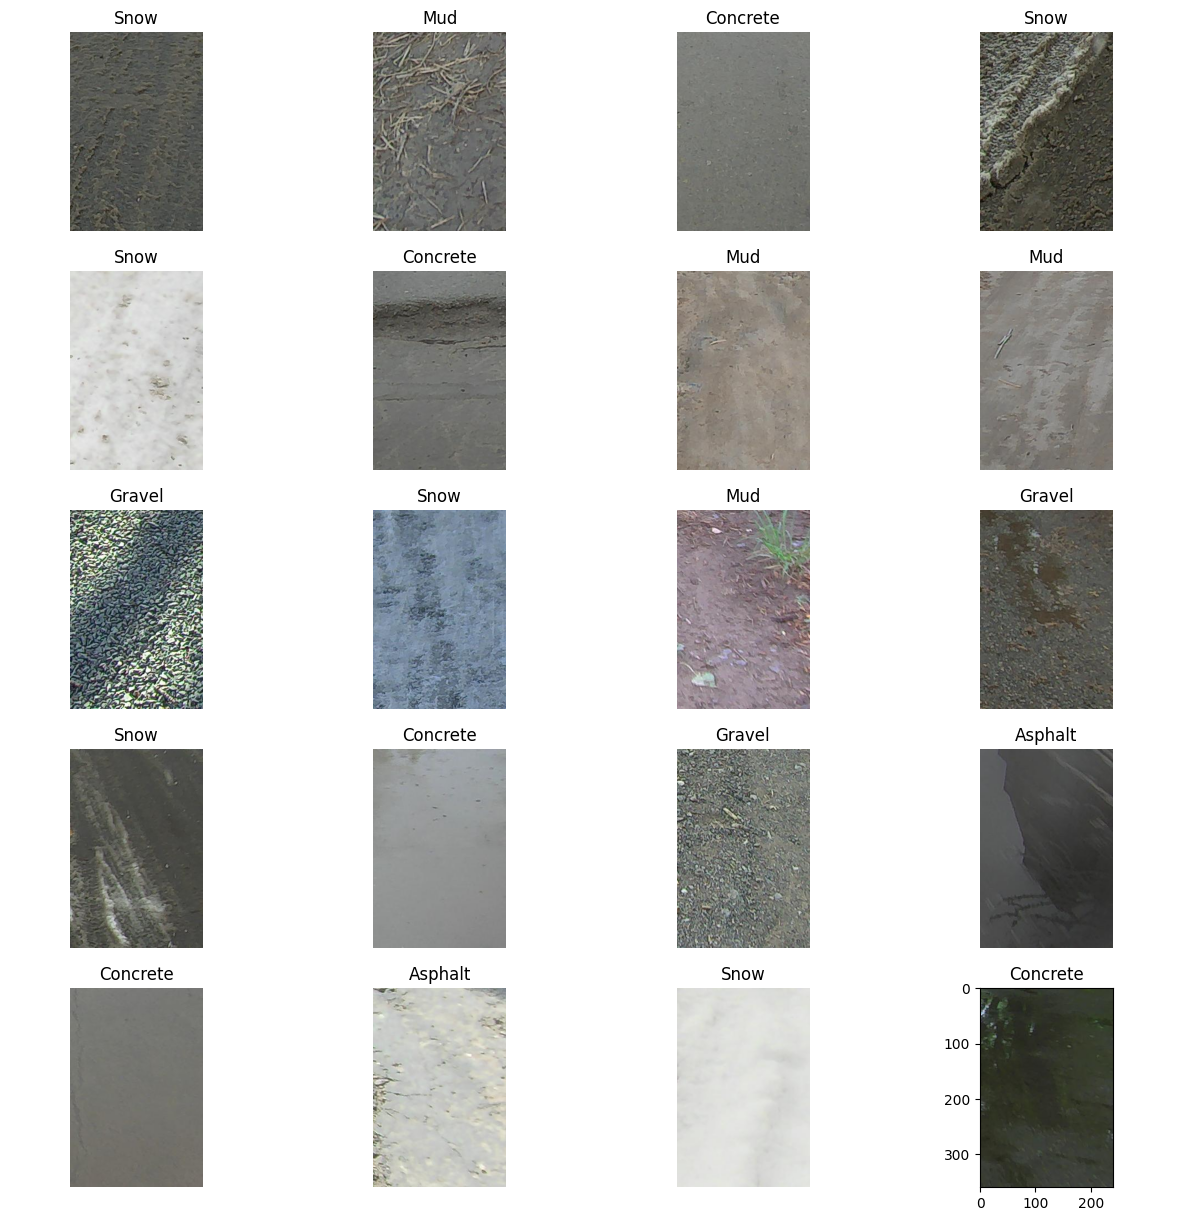

In [ ]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.2, stratify = labels)#stratify = labels


from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
from keras.models import Sequential, load_model
import tensorflow_addons as tfa
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2DTranspose,ReLU 
from keras.optimizers import Adam as adam
from keras.optimizers import SGD
from keras.metrics import RootMeanSquaredError
from keras import initializers
import math

initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

#Building the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5,activation='ReLU' ,input_shape=np.array(X_train).shape[1:]))
model.add(Conv2D(filters=32, kernel_size=5,activation='ReLU'))


model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.05))

model.add(Conv2D(filters=64, kernel_size=5,activation='ReLU'))
model.add(Conv2D(filters=64, kernel_size=5,activation='ReLU'))


model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=128, kernel_size=3,activation='ReLU'))
model.add(Conv2D(filters=128, kernel_size=3,activation='ReLU'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.15))

model.add(Conv2D(filters=256, kernel_size=3,activation='ReLU'))
model.add(Conv2D(filters=256, kernel_size=3,activation='ReLU'))


model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.15))

# model.add(Conv2D(filters=512, kernel_size=3,activation='ReLU'))
# model.add(Conv2D(filters=512, kernel_size=3,activation='ReLU'))


# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
# model.add(Dropout(rate=0.15))

# # model.add(Conv2D(filters=1024, kernel_size=3,activation='ReLU'))
# # model.add(Conv2D(filters=1024, kernel_size=3,activation='ReLU'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))
model.add(Dropout(rate=0.15))

model.add(GlobalAveragePooling2D()) 
model.add(Dense(num_classes,kernel_initializer=initializer, bias_initializer=initializer, activation='softmax')) 

model.compile(optimizer = adam(0.00001), loss = 'binary_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 356, 236, 32)      2432      
                                                                 
 conv2d_23 (Conv2D)          (None, 352, 232, 32)      25632     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 176, 116, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 176, 116, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 176, 116, 32)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 172, 112, 64)     

In [ ]:
# import LRFinder
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=10, batch_size=5, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [ ]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_f1_score"]
        accuracy = sum(accuracy) / len(accuracy)
        if accuracy >= self.point:
            self.model.stop_training = True


In [ ]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=100,callbacks = [StopOnPoint(0.90)],validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


   6/2000 [..............................] - ETA: 1:52 - loss: 0.7023 - f1_score: 0.1067

2000/2000 [==============================] - 140s 63ms/step - loss: 0.6551 - f1_score: 0.3652 - val_loss: 0.6337 - val_f1_score: 0.4914
Epoch 2/50
2000/2000 [==============================] - 129s 64ms/step - loss: 0.6231 - f1_score: 0.4197 - val_loss: 0.6121 - val_f1_score: 0.3962
Epoch 3/50
2000/2000 [==============================] - 126s 63ms/step - loss: 0.6003 - f1_score: 0.4374 - val_loss: 0.5731 - val_f1_score: 0.4498
Epoch 4/50
2000/2000 [==============================] - 126s 63ms/step - loss: 0.5712 - f1_score: 0.4588 - val_loss: 0.5705 - val_f1_score: 0.3982
Epoch 5/50
2000/2000 [==============================] - 129s 64ms/step - loss: 0.5421 - f1_score: 0.4664 - val_loss: 0.5094 - val_f1_score: 0.4842
Epoch 6/50
2000/2000 [==============================] - 129s 64ms/step - loss: 0.5133 - f1_score: 0.4818 - val_loss: 0.5160 - val_f1_score: 0.3902
Epoch 7/50
2000/2000 [==============================] - 129s 65ms/step - loss: 0.4827 - f1_score: 0.4926 - val_loss: 0.4653 - val

KeyboardInterrupt: ignored

In [ ]:
# Epoch 10/10
# 96/96  loss: 1.0394 - f1_score: 0.5776 - val_loss: 1.1017 - val_f1_score: 0.4925
# 240/240 loss: 1.0872 - f1_score: 0.5724 - val_loss: 0.8634 - val_f1_score: 0.5928
# 480/480 loss: 1.0734 - f1_score: 0.5655 - val_loss: 1.1409 - val_f1_score: 0.6127
# 600/600 loss: 1.0205 - f1_score: 0.5762 - val_loss: 0.8377 - val_f1_score: 0.6722

In [ ]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
test_data = []
test_labels = []
# end=2000
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
        count=0
        for file_number_3 in os.listdir(path3):
            count = count+1
            if count >= end:
                if count == end+100: break
                imagepath = (path3 + "/" + str(file_number_3))
                image = cv2.imread(imagepath, 1) ## Считываем изображение
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
    #             image = cv2.resize(image, input_size)
                test_data.append(image)
                label = file_number
                test_labels.append(label)

In [ ]:
len(test_data)

In [ ]:
len(test_labels)

In [ ]:
test_labels = le.fit_transform(test_labels)
# test_labels = to_categorical(test_labels, num_classes)

In [ ]:
predicted_classes = []
for i in range(len(test_data)):
    img_batch = np.expand_dims(test_data[i],0)
    prediction = model.predict(img_batch)
    prediction = np.argmax(prediction, axis=1)
    if prediction != test_labels[i]: print(prediction, '|', test_labels[i])
    predicted_classes.append(prediction[0])

In [ ]:
from sklearn.metrics import f1_score
print (f1_score(test_labels, predicted_classes, average='weighted'))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(test_labels, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')

In [ ]:
# model.save('./saved_models/Road_Type_AllClasses_CNN.h5')